# Ноутбук с нейронкой для предсказаний

В этом ноутбуке применяется так называемая "гибридная" стратегия обучения. Смысл ее в том, что цикл обучения происходит по классической схеме: используем заранее подготовленный датасет (маски - таргеты и симуляции от них) и минимизируем функцию потерь между предсказанием и таргетом. Валидация и тест проводятся иначе: от подготовленных картин делается предсказание, от предсказания делается симуляция и лосс вычисляется между симуляцией и исходной картиной.

Предполагается, что такая стратегия:

- Будет не настолько вычислительно сложной, как обучение по схеме predict-simulation-loss

- Будет лучше подходить под практическое применение, когда маска действительно не известна

## Подготовка данных

Скачиваем библиотеки, необходимые для симуляции. Установку надо прервать на моменте "Building wheels for cupy".

In [ ]:
!pip install pyffs
!pip install cupy

Импортируем

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision

from tqdm import tqdm
from copy import deepcopy
from timeit import default_timer
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, log_loss
from sklearn.metrics import RocCurveDisplay, roc_curve, auc


import torch.nn as nn
import torch.nn.functional as F

from torchsummary import summary
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.utils.data import random_split

import gc
from PIL import Image
from pyffs import ffsn, iffsn
import cupy as cp
import scipy.stats as sps

Подключаем Google диск

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Загружаем данные: бинарные маски, симуляции дифракции по ним и картинки дифракции

In [2]:
dataset = np.load('/content/drive/MyDrive/dataset.npy', allow_pickle=True)
simulations = np.load('/content/drive/MyDrive/simulations.npy', allow_pickle=True)
sim_pattern = np.load('/content/drive/MyDrive/sim_pattern.npy', allow_pickle=True)

Для работы с полным датасетом не хватает вычислительной мощности. Поэтому отрезаем от него часть.

In [3]:
device = torch.device('cuda')

N_start = 0
N_end = simulations.shape[0]
data_step = 3
X = torch.from_numpy(simulations[N_start:N_end:data_step].reshape(-1, 1, 513, 513)).half().to(device)
y = torch.from_numpy(dataset[N_start:N_end:data_step].reshape(-1, 1, 513, 513)).half().to(device)
Z = torch.from_numpy(sim_pattern[:100].reshape(-1, 1, 513, 513)).half().to(device)

Освобождаем память

In [4]:
del simulations
# del dataset

Делим данные на обучение, валидацию и тест

In [5]:
bs = 5

Z_val, Z_test = train_test_split(Z, test_size=0.7, random_state=42)

train_data = TensorDataset(X, y)
val_data = TensorDataset(Z_val)
test_data = TensorDataset(Z_test)

train_loader = DataLoader(train_data, batch_size=bs)
val_loader = DataLoader(val_data, batch_size=bs)
test_loader = DataLoader(test_data, batch_size=bs)

scaler = torch.cuda.amp.GradScaler()
tvc_factor = 16

## Симуляция ATL

Функции из ноутбука atl_simulation.ipynb

In [6]:
def my_matmul(a, m):
    if np.isscalar(a):
        return a * m
    else:
        return np.outer(a, m).reshape(len(a), m.shape[0], m.shape[1])
    
def compute_carpet(mask, wavelength, T_x, T_y, z):
    '''
    Функция для вычисления ковра Талбота
    param mask: изображение маски,
    param wavelength: длина волны [мм],
    param T_x: период маски по оси x [мм],
    param T_y: период маски по оси y [мм],
    param z: расстояние от картины до маски [мм]

    return: изображение картины
    '''

    mask_array = cp.sqrt(mask)
    
    N = mask_array.shape[0]
    n = (N - 1) // 2

    T = cp.array([T_x, T_y])
    T_c = T / 2
    N_FS = [N, N]
    
    F = ffsn((mask_array), T, T_c, N_FS)
    f_x = cp.reshape(cp.arange(-n, n + 1) / T[0], (1, -1))
    f_y = cp.reshape(cp.arange(-n, n + 1) / T[1], (-1, 1))

    H = cp.exp(-1j * cp.pi * z * my_matmul(wavelength, (cp.power(f_x, 2) + cp.power(f_y, 2))))
    result_array = (iffsn((F * H), T, T_c, N_FS, axes=[1, 2]))
    return cp.square(cp.absolute(result_array))

def compute_atl(mask, T_x = 0.001, T_y = 0.001, wl = 1.35e-5, rel_delta_wl = 0.04):
    '''
    Функция для вычисления дифракционной картины ATL
    param mask: изображение маски,
    param T_x: период маски по оси x [мм],
    param T_y: период маски по оси y [мм],
    param wl: длина волны [мм],
    param rel_delta_wl: относительная немонохроматичность [мм]

    return: изображение картины
    '''

    grid_size = 500
    c = 299792458e3 # speed of light in mm/s
    freq = c / wl
    delta_freq = freq * rel_delta_wl
    freq_grid = cp.linspace(freq - delta_freq, freq + delta_freq, grid_size)

    grid = cp.linspace(-2, 2, grid_size)
    intens = sps.norm.pdf(grid.get())
    
    z_A = 2 * max(T_x, T_y) ** 2 / (rel_delta_wl * wl)
    carp = compute_carpet(mask, (c / freq_grid), T_x, T_y, 2 * z_A)
    return cp.average(carp, axis=0, weights=intens).astype(cp.float16)

def compute_atl_4tensor(X):
    masks = cp.where(cp.asarray(X.clone().detach()).reshape(-1, 513, 513) > 128, 255, 0)
    pics = []
    for i in range(masks.shape[0]):
        pics.append(compute_atl(masks[i]).get())
    return torch.tensor(np.array(pics).reshape(-1, 1, 513, 513), requires_grad=True).half().to(device)


## Обучение модели

### Функция, которая обучает модель

На обучении считаем лосс между предсказанием и таргетом, а на валидации между симуляцией от предсказания и исходной картиной.

In [7]:
def train(model, criterion, optimizer, X, n_epochs, n_stop=10):
    min_val_loss = np.inf
    f = 0
    for epoch in range(n_epochs):
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            _X, _y = batch
            _X, _y = _X.to(device), _y.to(device)
          
            with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                _y_pred = model(_X)
                loss = criterion(_y_pred, _y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        model.eval()
        mean_val_loss = 0
        batch_count = 0
        for batch in val_loader:
            _X = batch[0].to(device)
            with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                _y_pred = model(_X / tvc_factor)
            _X_sim = compute_atl_4tensor(_y_pred)
            loss = criterion(_X / tvc_factor, _X_sim)
            mean_val_loss += loss.item()
            batch_count += 1

        mean_val_loss /= batch_count

        if epoch % 10 == 0:
            print(f'Epoch: {epoch}, \tValidation loss: {(mean_val_loss)}')

        if round(mean_val_loss, 3) >= min_val_loss:
            f = f + 1
        else:
            f = 0
            best_model = deepcopy(model)
            min_val_loss = round(mean_val_loss, 3)
        if f >= n_stop:
            print(f'epoch: {epoch}, val loss did not decrease for {f} epoch(s)')
            break

    return best_model #, train_loss, val_loss

### Функция для подсчета ошибки на тесте

Делаем то же, что и при валидации, но без GPU и без использования mixed precision training. Здесь нам не так важна скорость, но важно сберечь видеопамять.

In [8]:
def test_loss(model, criterion):
  mean_loss = 0
  batch_count = 0
  for batch in test_loader:
    with torch.no_grad():
      _X = batch[0].cpu().float()
      # with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
      model.cpu()
      _y_pred = model(_X / tvc_factor)
      _X_sim = compute_atl_4tensor(_y_pred).cpu()
      loss = criterion(_X / tvc_factor, _X_sim)
      mean_loss += loss.item()
      batch_count += 1
    
  return mean_loss / batch_count

Два варианта модели CNN

In [ ]:
# Define the CNN architecture
ch_b = 4
class CNN1(torch.nn.Module):
  def __init__(self):
    super(CNN1, self).__init__()
    self.conv1 = torch.nn.Conv2d(1, ch_b, kernel_size=3, padding=2, dilation=2) # 513
    self.pool1 = torch.nn.MaxPool2d(kernel_size=2)                # 256
    self.conv2 = torch.nn.Conv2d(ch_b, ch_b * 2, kernel_size=3, padding=2, dilation=2) # 256
    self.pool2 = torch.nn.MaxPool2d(kernel_size=2)                # 128
    self.fc1 = torch.nn.Linear(ch_b * 2 * 128 * 128, 128)
    self.fc2 = torch.nn.Linear(128, 513 * 513)

  def forward(self, x):
    x = self.conv1(x)
    x = torch.relu(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = torch.relu(x)
    x = self.pool2(x)
    x = x.view(-1, ch_b * 2 * 128 * 128)
    x = self.fc1(x)
    x = torch.relu(x)
    x = self.fc2(x)
    x = torch.relu(x)
    return x.view(-1, 1, 513, 513)

In [9]:
# Define the CNN architecture
ch_b = 2
class CNN2(torch.nn.Module):
  def __init__(self):
    super(CNN2, self).__init__()
    self.conv1 = torch.nn.Conv2d(1, ch_b, kernel_size=6, padding=5, dilation=2) # 513
    self.pool1 = torch.nn.MaxPool2d(kernel_size=2)                # 256
    self.conv2 = torch.nn.Conv2d(ch_b, ch_b*2, kernel_size=6, padding=5, dilation=2) # 256
    self.pool2 = torch.nn.MaxPool2d(kernel_size=2)                # 128
    self.fc1 = torch.nn.Linear(ch_b * 2 * 128 * 128, 128)
    self.fc2 = torch.nn.Linear(128, 513 * 513)

  def forward(self, x):
    x = self.conv1(x)
    x = torch.relu(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = torch.relu(x)
    x = self.pool2(x)
    x = x.view(-1, ch_b * 2 * 128 * 128)
    x = self.fc1(x)
    x = torch.relu(x)
    x = self.fc2(x)
    x = torch.relu(x)
    return x.view(-1, 1, 513, 513)

В этой ячейке можно проверить работу слоя

In [ ]:
# m = nn.MaxPool2d(kernel_size=4)
m = torch.nn.Conv2d(1, 1, kernel_size=3, padding=2, dilation=2, stride=2)
s = 256
input = torch.randn(1, s, s)
output = m(input)
output.size()

torch.Size([1, 128, 128])

Обучаем модель

In [ ]:
# Instantiate the CNN
model = CNN2().to(device)
model.cuda()

# Define the loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# with torch.autograd.detect_anomaly(check_nan=True):
model = train(model, criterion, optimizer, X, n_epochs=1000, n_stop=100)

Можно загрузить уже обученную модель

In [12]:
model_other = torch.load('/content/drive/MyDrive/models/hybrid689', map_location=torch.device('cpu')).to(device)
# model.cuda()

Считаем ошибку на тесте

In [13]:
criterion = torch.nn.MSELoss()
print(f'Test loss: {test_loss(model, criterion)}')
print(f'Test loss: {test_loss(model_other, criterion)}')

Test loss: 73.31800324576241
Test loss: 613.7301276070731


Сохраняем модель, если понравилась

In [14]:
torch.save(model, '/content/drive/MyDrive/models/hybrid73')

## Проверка модели на практике

Следующие ячейки нужны для предсказания маски для какой-то конкретной картинки. Это предсказание можно сохранить, сделать по нему симуляцию и сравнить ее с исходной картинкой. 

In [33]:
def frame_plot(arr, ax):
  rectX = np.linspace(0, 1, arr.shape[0])
  rectY = np.linspace(0, 1, arr.shape[1])
  x, y = np.meshgrid(rectX, rectY)
  ax.pcolormesh(x, y, arr)

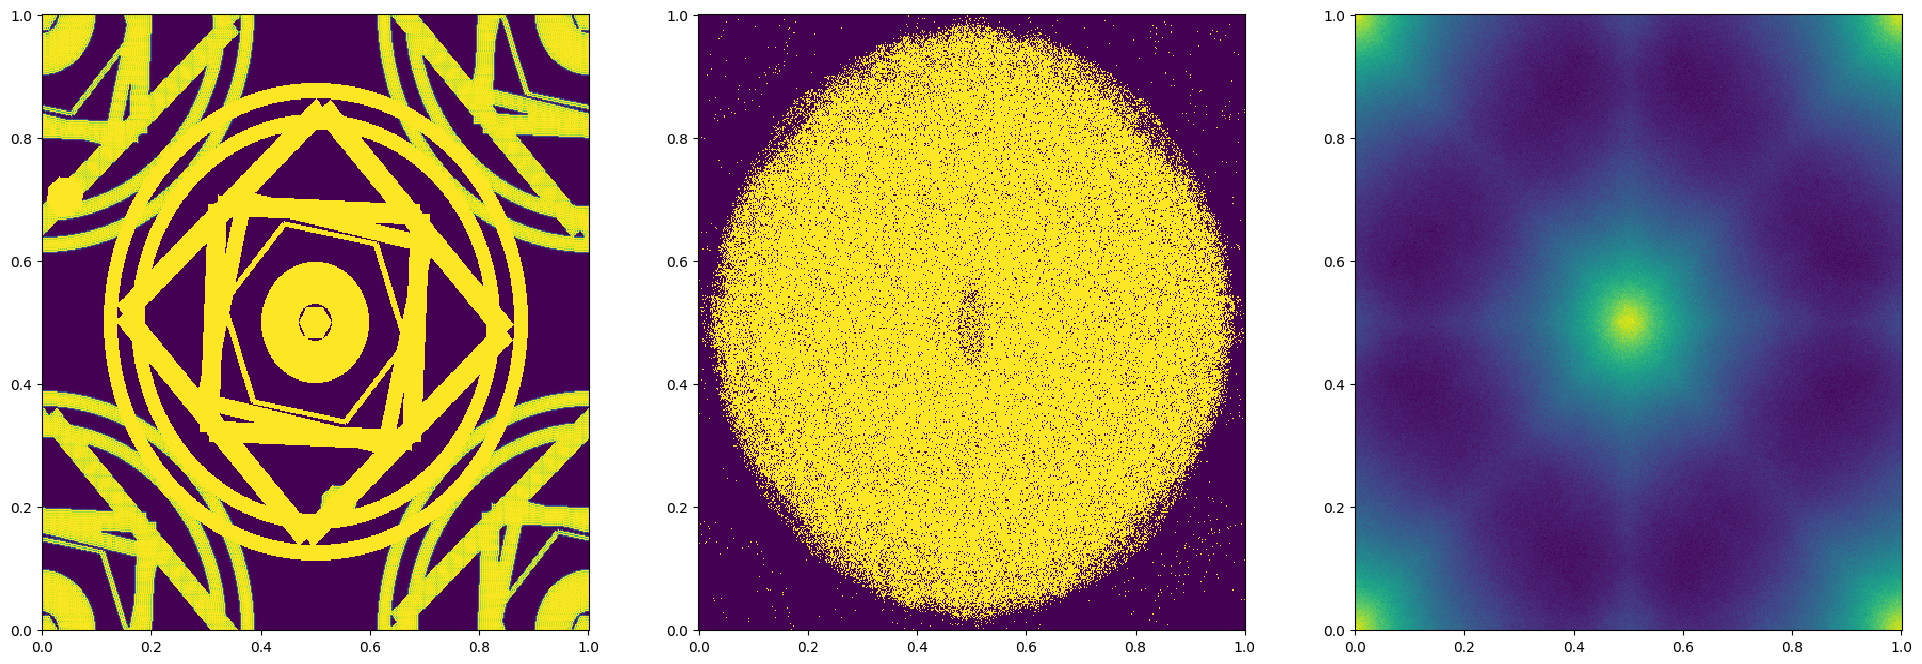

In [40]:
# pic_np = np.array(Image.open('/content/drive/MyDrive/prediction_test/cooler_im10.png').convert("L"))
pic_np = sim_pattern[105]
# pic_np = np.load('/content/drive/MyDrive/dif/sim18.npy')
pic =  torch.from_numpy(pic_np.reshape(1, 513, 513)).half().to(device)
model.cuda()
with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
  pic_pred = model(pic)

pic_pred_np = np.where(pic_pred.clone().cpu().detach().numpy().reshape(513, 513) > 128, 255, 0)
sim_from_pred = compute_atl_4tensor(pic_pred).cpu().detach().numpy().reshape(513, 513)

fig, ax = plt.subplots(1, 3, figsize=(24, 8))
frame_plot(pic_np, ax=ax[0])
frame_plot(pic_pred_np, ax=ax[1])
frame_plot(sim_from_pred, ax=ax[2])

In [37]:
pic_pred_np[200][200]

602.5

In [ ]:
circle_im = Image.fromarray(pic_pred_np.astype(np.uint8))
circle_im = circle_im.convert('L')
circle_im.show()
circle_im.save('/content/drive/MyDrive/prediction_test/circle_pred.png')